Load Frozen Graph
=========
### Test loading a frozen graph from ".pb" file for deployment on website.

In [12]:
import _init_paths
import tensorflow as tf
import glob
from fast_rcnn.config import cfg
# The following line specifies CPU operation for importing the following modules.
#cfg.USE_GPU_NMS = False
#from fast_rcnn.nms_wrapper import nms
# Import roi_pooling_op which is dynamically-linked at runtime.
import roi_pooling_layer.roi_pooling_op as roi_pool_op
#import roi_pooling_layer.roi_pooling_op_grad
#from rpn_msr.proposal_layer_tf import proposal_layer as proposal_layer_py
#from rpn_msr.anchor_target_layer_tf import anchor_target_layer as anchor_target_layer_py
#from rpn_msr.proposal_target_layer_tf import proposal_target_layer as proposal_target_layer_py
# Import function to convert image to feed_dict
from fast_rcnn.test import _get_blobs
from utils.timer import Timer
import matplotlib.pyplot as plt
import numpy as np
import os, sys, cv2
#from networks.factory import get_network
% matplotlib inline

In [13]:
labels = ('__background__',
           'empty_basket', 'full_basket')

In [14]:
#path = '/Users/LukeMiller/Git/tensorflow_faster_rcnn/output/BSKT_VGG16/voc_2007_trainval/'
path = '/root/faster_rcnn/output/BSKT_VGG16/voc_2007_trainval/'

In [15]:
#im_dir = '/Users/LukeMiller/Dropbox (Kontingenz)/cartwatch/classification/examples/'
im_dir = '/root/faster_rcnn/data/VOCdevkit/VOC2007/JPEGImages/'

### Open session and load model

In [16]:
def session_open():
    # Read graph
    with tf.gfile.FastGFile(path + "VGGnet_fast_rcnn_iter_20000.pb", 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def, name='')

    print("classifier:setup :: done loading model")

    session = tf.Session()
    return session

In [17]:
def classify(session, feed_dict):
    softmax_tensor = session.graph.get_tensor_by_name('cls_prob:0')
    bbox_tensor = session.graph.get_tensor_by_name('bbox_pred/bbox_pred:0')
    return session.run([softmax_tensor, bbox_tensor], feed_dict)

In [18]:
def parse_output(classification):
    values = classification.tolist()[0]

    result = [{"label": lbl, "value": val} for lbl, val in zip(labels, values)]
    relevant_keys = ["full cart", "empty cart"]
    result[:] = [d for d in result if d.get('label') in relevant_keys]
    return result

In [19]:
def read_and_convert_image(session, image_name):
    content = tf.gfile.FastGFile(image_name, 'rb').read()

    decoder = None
    name = image_name.lower()

    if name.endswith('jpg') or name.endswith('jpeg'):
        decoder = tf.image.decode_jpeg(content, channels=3)
    elif name.endswith('png'):
        decoder = tf.image.decode_png(content, channels=3)
    elif name.endswith('gif'):
        decoder = tf.image.decode_gif(content)
    else:
        raise(ValueError("Unsupported file type"))

    return decoder.eval(session=session)

In [20]:
def convert_to_feed_dict(im, boxes = None):
    blobs, im_scales = _get_blobs(im, boxes)

    im_blob = blobs['data']
    blobs['im_info'] = np.array(
        [[im_blob.shape[1], im_blob.shape[2], im_scales[0]]],
        dtype=np.float32)
    # forward pass
    feed_dict={'Placeholder:0': blobs['data'], 'Placeholder_1:0': blobs['im_info']}
    #feed_dict={'Placeholder:0': blobs['data'], 'Placeholder_1:0': blobs['im_info'], 'Placeholder_2:0': [np.array([1])]}
    return feed_dict

In [21]:
def run(session,image_name):
    converted_image = read_and_convert_image(session, image_name)
    return parse_output(classify(session, converted_image))

In [22]:
session = session_open()

classifier:setup :: done loading model


In [23]:
for image_name in glob.glob(im_dir+'/*.jpg')[0:1]:
    converted_image = read_and_convert_image(session, image_name)
    feed_dict = convert_to_feed_dict(converted_image)
    print(np.shape(feed_dict['Placeholder:0']))
    print(feed_dict['Placeholder_1:0'])
    

(1, 600, 806, 3)
[[ 600.          806.            1.79104483]]


In [31]:
with tf.gfile.FastGFile(path + "VGGnet_fast_rcnn_iter_20000.pb", 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    for node in graph_def.node:
        print(node.name)
        #print(node.op),
        #print(node.input)

Placeholder
Placeholder_1
conv1_1/weights
conv1_1/weights/read
conv1_1/biases
conv1_1/biases/read
conv1_1/Conv2D
conv1_1/BiasAdd
conv1_1/conv1_1
conv1_2/weights
conv1_2/weights/read
conv1_2/biases
conv1_2/biases/read
conv1_2/Conv2D
conv1_2/BiasAdd
conv1_2/conv1_2
pool1
conv2_1/weights
conv2_1/weights/read
conv2_1/biases
conv2_1/biases/read
conv2_1/Conv2D
conv2_1/BiasAdd
conv2_1/conv2_1
conv2_2/weights
conv2_2/weights/read
conv2_2/biases
conv2_2/biases/read
conv2_2/Conv2D
conv2_2/BiasAdd
conv2_2/conv2_2
pool2
conv3_1/weights
conv3_1/weights/read
conv3_1/biases
conv3_1/biases/read
conv3_1/Conv2D
conv3_1/BiasAdd
conv3_1/conv3_1
conv3_2/weights
conv3_2/weights/read
conv3_2/biases
conv3_2/biases/read
conv3_2/Conv2D
conv3_2/BiasAdd
conv3_2/conv3_2
conv3_3/weights
conv3_3/weights/read
conv3_3/biases
conv3_3/biases/read
conv3_3/Conv2D
conv3_3/BiasAdd
conv3_3/conv3_3
pool3
conv4_1/weights
conv4_1/weights/read
conv4_1/biases
conv4_1/biases/read
conv4_1/Conv2D
conv4_1/BiasAdd
conv4_1/conv4_1
conv

In [18]:
classify(session, feed_dict)

KeyError: 'pyfunc_0'

InternalError: Failed to run py callback pyfunc_0: see error log.
	 [[Node: PyFunc = PyFunc[Tin=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_STRING, DT_INT32, DT_INT32], Tout=[DT_FLOAT], token="pyfunc_0", _device="/job:localhost/replica:0/task:0/cpu:0"](rpn_cls_prob_reshape/_19, rpn_bbox_pred/rpn_bbox_pred/_21, _recv_Placeholder_1_0, PyFunc/input_3, PyFunc/input_4, PyFunc/input_5)]]
	 [[Node: PyFunc/_23 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_228_PyFunc", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op u'PyFunc', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-ee3839263221>", line 1, in <module>
    session = session_open()
  File "<ipython-input-4-0cc200330aae>", line 6, in session_open
    tf.import_graph_def(graph_def, name='')
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/importer.py", line 285, in import_graph_def
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

InternalError (see above for traceback): Failed to run py callback pyfunc_0: see error log.
	 [[Node: PyFunc = PyFunc[Tin=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_STRING, DT_INT32, DT_INT32], Tout=[DT_FLOAT], token="pyfunc_0", _device="/job:localhost/replica:0/task:0/cpu:0"](rpn_cls_prob_reshape/_19, rpn_bbox_pred/rpn_bbox_pred/_21, _recv_Placeholder_1_0, PyFunc/input_3, PyFunc/input_4, PyFunc/input_5)]]
	 [[Node: PyFunc/_23 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_228_PyFunc", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


### Define function to capture image from webcam
30 frames are taken to allow the camera to adjust to the lighting conditions.

In [8]:
def get_image(feed,ramp_frames=30):
    for i in xrange(ramp_frames):
        temp = feed.read()[1]
    # Capture image after adjusting to lighting conditions
    return feed.read()[1]

### Perform inference on image captured from webcam

Detection took 5.436s for 237 object proposals


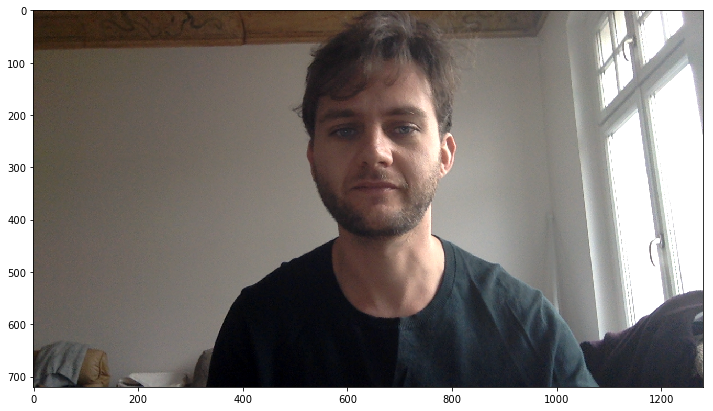

In [11]:
# Unless more than one webcam is plugged in, the default is '0'
feed = cv2.VideoCapture(0)
# Capture frame from webcam
current_frame = get_image(feed)
# Release after capture
feed.release()
# Perform inference
demo(sess, net, current_frame)
plt.show()